有关训练Gradient Boosting模型的端到端演练，请查看boosted trees教程。在本教程中，您将：

* 了解如何本地和全局解释Boosted Trees模型
* 获得有关Boosted Trees模型如何适合数据集的直觉

如何在本地和全局解释Boosted Trees模型<br>
局部可解释性是指对单个示例级别的模型预测的理解，而全局可解释性是指对模型的整体理解。这样的技术可以帮助机器学习（ML）专业人员在模型开发阶段检测偏差和错误。

对于本地可解释性，您将学习如何创建和可视化每个实例的贡献。为了与特征重要性区分开来，我们将这些值称为定向特征贡献（DFC）。

对于全局可解释性，您将检索并可视化基于增益的特征重要性，置换特征重要性，并显示汇总的DFC。

加载泰坦尼克号数据集<br>
您将使用泰坦尼克号数据集，其中（而不是病态）目标是根据给定的特征（例如性别，年龄，阶级等）来预测乘客的生存。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

In [3]:
import tensorflow as tf
tf.random.set_seed(123)

有关功能的描述，请查看以前的教程。

创建要素列，input_fn和训练估算器

预处理数据

使用原始数字列和“一键编码”分类变量创建要素列。

In [4]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

建立输入管道

使用API中的from_tensor_slices方法创建输入函数，tf.data以直接从Pandas中读取数据。

In [5]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

训练模型

In [6]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.806818
accuracy_baseline,0.625000
auc,0.866606
auc_precision_recall,0.849128
average_loss,0.421549
label/mean,0.375000
loss,0.421549
precision,0.755319
prediction/mean,0.384944
recall,0.717172


出于性能原因，当您的数据适合内存时，我们建议使用该boosted_trees_classifier_train_in_memory功能。但是，如果培训时间无关紧要，或者您的数据集非常大并且想要进行分布式培训，请使用tf.estimator.BoostedTrees上面显示的API。

使用此方法时，不应对输入数据进行批处理，因为该方法将对整个数据集进行操作。

In [7]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.806818
accuracy_baseline,0.625000
auc,0.868105
auc_precision_recall,0.854259
average_loss,0.417260
label/mean,0.375000
loss,0.417260
precision,0.755319
prediction/mean,0.386102
recall,0.717172


模型解释和绘图

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

本地可解释性

接下来，您将输出方向特征贡献（DFC），以使用Palczewska等人和 Saabas在“ 解释随机森林”中概述的方法来解释单个预测（此方法在scikit-learn中也可用于随机森林的treeinterpreter软件包中）。DFC通过以下方式生成：

pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))

（注意：该方法称为实验方法，因为我们可以在删除实验前缀之前修改API。）

In [9]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\sha\\AppData\\Local\\Temp\\tmpwifyd11s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C67B2C22E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done ca

In [10]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.025285,0.085606,-0.172007,-0.075237,-0.051290,0.011908,0.466216
sex,264.0,0.008138,0.108147,-0.097388,-0.074132,-0.072698,0.138499,0.197285
class,264.0,0.017317,0.093436,-0.075741,-0.045486,-0.044461,0.035060,0.248212
deck,264.0,-0.016094,0.033232,-0.096513,-0.042359,-0.026754,0.005053,0.205399
fare,264.0,0.016471,0.089597,-0.330205,-0.031050,-0.011403,0.050212,0.229989
embark_town,264.0,-0.007320,0.027672,-0.053676,-0.015208,-0.014375,-0.003016,0.068483
n_siblings_spouses,264.0,0.003973,0.027914,-0.144680,0.003582,0.004825,0.006412,0.138123
parch,264.0,0.001342,0.007995,-0.062833,0.000405,0.000510,0.002834,0.048722
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


DFC的一个不错的特性是，贡献的总和+偏差等于给定示例的预测。

In [11]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [12]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8 # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

绘制单个乘客的DFC。让我们通过基于贡献的方向性的颜色编码来使图更美观，并在图形上添加特征值。

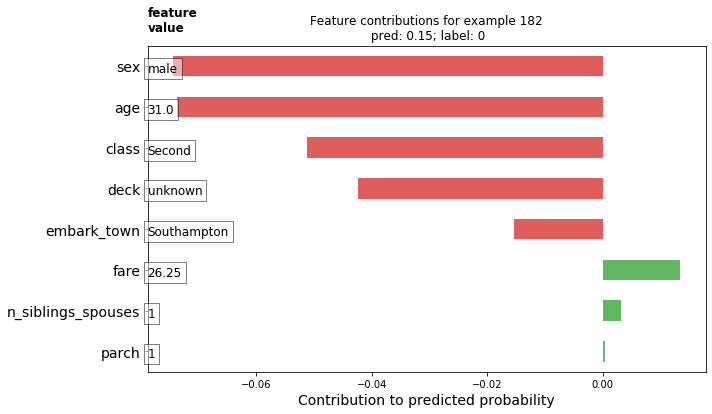

In [13]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

较大的量级贡献对模型的预测有较大的影响。负贡献表示此给定示例的特征值降低了模型的预测，而正值则贡献了预测的增加。

您还可以使用voilin图来绘制示例的DFC与整个分布的比较。

In [14]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
    # Initialize plot.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create example dataframe.
    TOP_N = 8  # View top 8 features.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # Add contributions of entire distribution.
    parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # Add local contributions.
    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

    # Legend
    # Proxy plot, to show violinplot dist on legend.
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
    legend.get_frame().set_facecolor('white')

    # Format plot.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

绘制此示例。

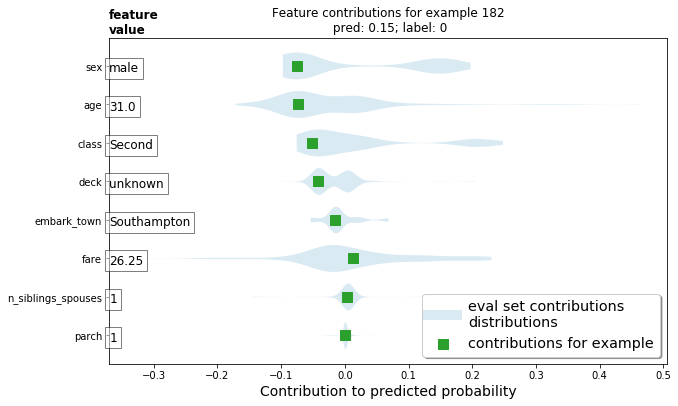

In [15]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

最后，第三方工具（例如LIME和shap）也可以帮助理解模型的各个预测。

全局功能的重要性<br>
此外，您可能想从整体上理解模型，而不是研究单个预测。在下面，您将计算和使用：

* 使用来获得基于特征的重要性 est.experimental_feature_importances
* 排列重要性
* 汇总使用的DFC est.experimental_predict_with_explanations

基于增益的特征重要性可衡量在拆分特定特征时的损耗变化，而排列特征的重要性是通过对评估集上的模型性能进行评估来计算的，方法是将特征逐一改组并将模型性能的变化归因于混洗后的特征。

通常，置换特征重要性要优先于基于增益的特征重要性，尽管在潜在的预测变量的测量范围或类别数量以及特征相关时（来源），两种方法都不可靠。请查看本文，以获取有关不同功能重要性类型的深入概述和精彩讨论。

基于增益的功能重要性<br>
使用的TensorFlow Boosted Trees估计器内置了基于增益的功能重要性est.experimental_feature_importances。

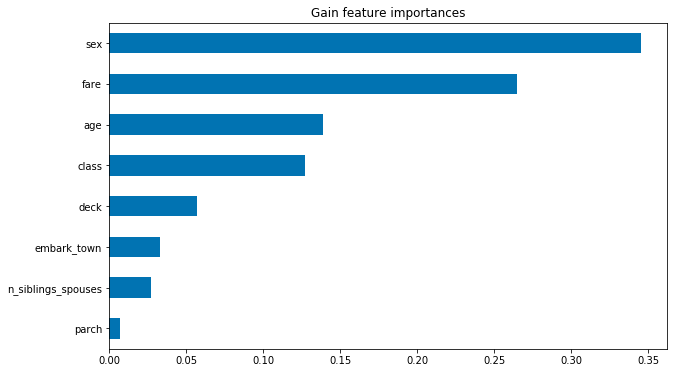

In [16]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

平均绝对DFC

您还可以平均DFC的绝对值，以了解全球范围内的影响。

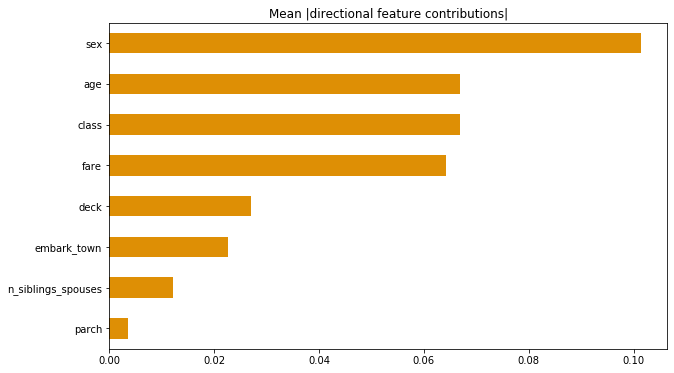

In [17]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

您还可以查看DFC如何随着功能值的变化而变化。

In [20]:
! pip install statsmodels

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


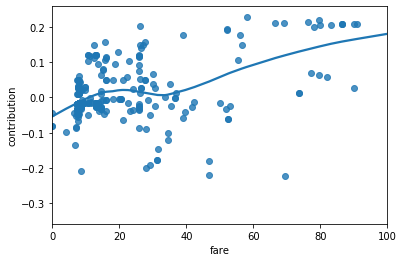

In [21]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

排列特征的重要性

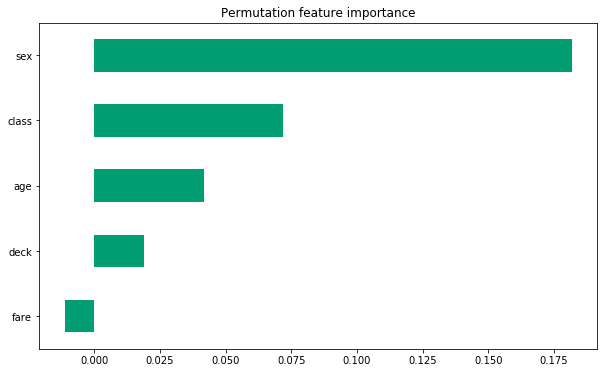

In [23]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
clear_output()
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

可视化模型拟合
首先使用以下公式模拟/创建训练数据：
$$
z=x*e^{-x^2-y^2}
$$
其中（z）是您要预测的因变量，而（x）和（y）是要素。

In [7]:
from numpy.random import uniform, seed
# from matplotlib.mlab import griddata
from  scipy.interpolate import griddata
import numpy as np
import pandas as pd
# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [8]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [9]:
def plot_contour(x, y, z, **kwargs):
    # Grid the data.
    plt.figure(figsize=(10, 8))
    # Contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()  # Draw colorbar.
    # Plot data points.
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

# 尝试解决 matplotlib 没有 griddata 的问题

In [10]:
z[:10]

array([ 0.14148831,  0.21306852,  0.01767334,  0.1227507 , -0.08830518,
        0.13734849, -0.0209978 ,  0.01763329,  0.02713429, -0.18279977])

In [11]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [12]:
grid_x.shape,grid_y.shape

((100, 200), (100, 200))

In [13]:
xi.shape,yi.shape

((210, 200), (210, 200))

In [14]:
points = np.random.rand(1000, 2)

In [15]:
points.shape

(1000, 2)

In [16]:
np.array((x, y)).T

array([[ 0.19525402, -0.53287912],
       [ 0.86075747, -0.80950328],
       [ 0.4110535 , -1.72560164],
       ...,
       [-1.21044695,  1.03371808],
       [-0.40525112, -1.90485029],
       [ 1.83437241,  1.25430032]])

In [17]:
zi = griddata(np.array((x, y)).T, z, (xi, yi), method='nearest')

In [18]:
zi.shape

(210, 200)

In [19]:
zi

array([[-0.00106972, -0.00106972, -0.00118   , ...,  0.00107715,
         0.00107715,  0.00088219],
       [-0.00106972, -0.00106972, -0.00106972, ...,  0.00107715,
         0.00108384,  0.00088219],
       [-0.00106972, -0.00106972, -0.00106972, ...,  0.00108384,
         0.00108384,  0.00088219],
       ...,
       [-0.00076652, -0.00076652, -0.00076652, ...,  0.00111312,
         0.00111312,  0.00111312],
       [-0.00076652, -0.00076652, -0.00076652, ...,  0.00111312,
         0.00111312,  0.00111312],
       [-0.00076652, -0.00076652, -0.00076652, ...,  0.00111312,
         0.00111312,  0.00111312]])

# 尝试解决 matplotlib 没有 griddata 的问题

您可以可视化该功能。红色代表较大的功能值。

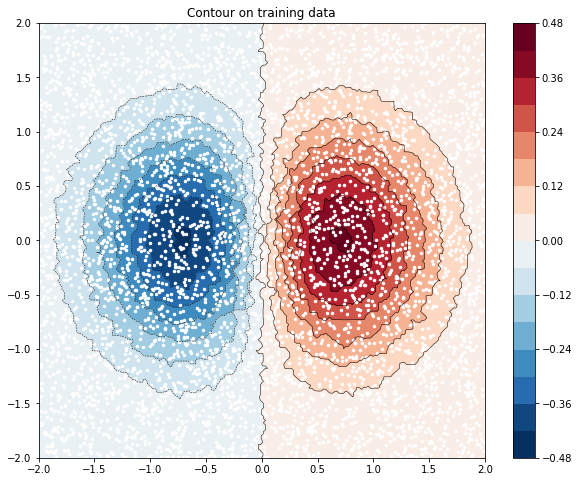

In [28]:
# zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi, extents=(0,1,0,1))
plt.scatter(df.x, df.y,c='w',marker='.',linewidths=0.5)
plt.title('Contour on training data')
plt.show()

In [35]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [36]:
zi[:10,:10]

array([[-0.00106972, -0.00106972, -0.00118   , -0.00118   , -0.00118   ,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00118   , -0.00118   ,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00118   , -0.00118   ,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00111829, -0.00118   ,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00111829, -0.00111829,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00106972, -0.00111829,
        -0.00118   , -0.00118   , -0.00118   , -0.00118   , -0.00118   ],
       [-0.00106972, -0.00106972, -0.00106972, -0.00106972, -0.00111829,
        -0.00111829, -0.00127871, -0.00118   

In [37]:
def predict(est):
    """Predictions from a given estimator."""
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

首先，让我们尝试将线性模型拟合到数据中。

In [38]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\30660\\AppData\\Local\\Temp\\tmplq9beskv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C56749A940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:C

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\30660\AppData\Local\Temp\tmplq9beskv\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


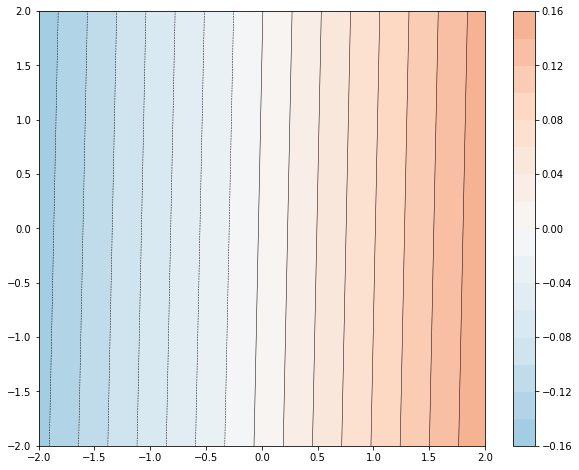

In [39]:
plot_contour(xi, yi, predict(est))

这不是一个很好的选择。接下来，让我们尝试将GBDT模型拟合到该模型，并尝试了解该模型如何适合该功能。

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\30660\AppData\Local\Temp\tmpo11b3bq6\model.ckpt-132
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


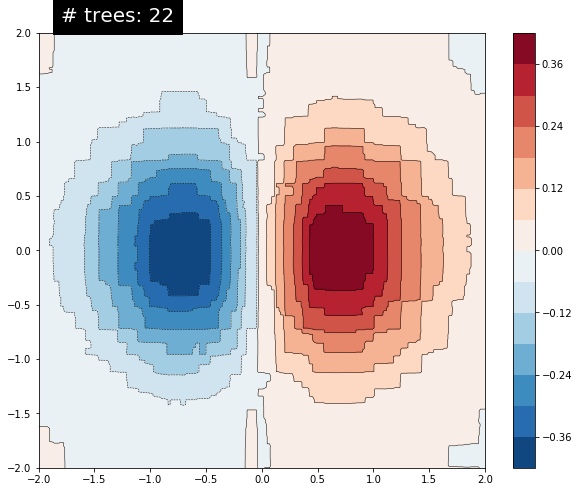

In [40]:
n_trees = 22 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()